In [1]:
### Author: Leonie Küchenhoff
### Date: November 30th 2022
### Purpose of script: 
### Plot allele frequency of on-target edits

In [2]:
# package import
import pandas as pd
import numpy as np
import allel
from config import basedir, outdir
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# directory settings
os.chdir(basedir)
outdir = str(outdir + '/on_target_AF')
print('This base directory will be used:\n', basedir)
os.chdir(basedir)

This base directory will be used:
 /g/steinmetz/project/leonie_crispr/03_data/02_rnaseq/snakemake/


In [4]:
# sample names
names = ['028_pbs_R', '029_pbs_R', '032_pbs_R','033_nrch_R', '030_nrch_R', '036_nrch_R', 
            '011_pbs', '012_nrch', '013_nrch', '014_nrch', '279_spry', '321_pbs', '333_pbs', '450_spry', '283_spry']
# treatment in same order as sample names
based_editor = ['pbs', 'pbs','pbs', '8e-NRCH', '8e-NRCH', '8e-NRCH',
            'pbs', '8e-NRCH', '8e-NRCH','8e-NRCH', 'max-SpRY', 'pbs', 'pbs', 'max-SpRY', 'max-SpRY']
paths = [f'variant_caller_out/H{i}.ontarget.hc.vcf.gz' for i in names] + [f'variant_caller_out/L{i}.ontarget.hc.vcf.gz' for i in names]

In [5]:
ref = np.zeros([len(names)*2, 2])
mutation = []
edit_positions = []
for count, i in enumerate(paths): 
    '''
    per sample, get read counts of on target site. On-target site differs, depending on the sample
    '''
    callset = allel.read_vcf(i, fields=['AD', 'POS'])
    # extract which tagret site this sample has
    if [names+names][0][count][-1] == 'R':
        index = np.where(callset['variants/POS'] == 53843243)[0][0]
        mutation.append('r636q')
    else:
        index = np.where(callset['variants/POS'] == 53843240)[0][0]
        mutation.append('p635l')
    
    # get position where alternative allele was measured to check for bystander edits
    edit_positions.append(np.where(np.array([i[0][1] for i in callset['calldata/AD']])!= 0))

    # store read counts for reference and alternative in numpy array
    ref[count,0] = callset['calldata/AD'][index][0][0]
    ref[count,1] = callset['calldata/AD'][index][0][1]


In [6]:
# summarize all info into pandas df
test = pd.DataFrame(ref, columns = ['alt','ref'])
test['sample'] = names+names
test['treatment'] = based_editor+based_editor
test['AF'] = 1-(ref[:,1] / (ref[:,0] + ref[:,1]))
test['tissue'] = ['heart']*len(names) + ['liver']*len(names) 
test = test.fillna(0)
test['mouse'] = [i[0:3] for i in test['sample']]
test['reads'] = test['alt'] + test['ref']
test['mutation']  = mutation

/tmp/ipykernel_17411/1496088556.py:5: RuntimeWarning: invalid value encountered in divide
  test['AF'] = 1-(ref[:,1] / (ref[:,0] + ref[:,1]))


In [7]:
p365l = test[test['mutation'] == 'p635l']

r636q = test[test['mutation'] == 'r636q']

In [8]:
plt.rcParams.update({'font.size':18, 'text.usetex': False,
"svg.fonttype": 'none'})

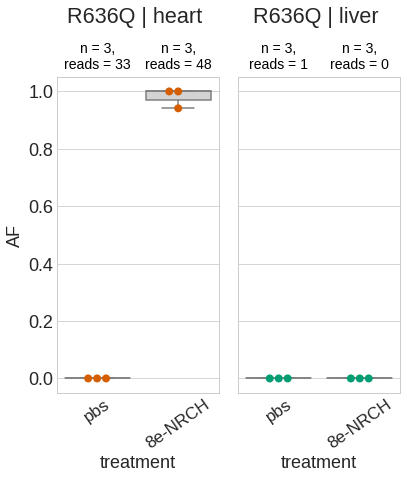

In [10]:
fig, ax = plt.subplots(1,2, figsize = (6,7), sharey = True)
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')
plot1 = sns.boxplot(x="treatment", y="AF", data=r636q[r636q['tissue'] == 'heart'], color = 'lightgrey', ax = ax[0])
sns.swarmplot(x="treatment", y="AF", data=r636q[r636q['tissue'] == 'heart'], size = 8, ax = ax[0], color = sns.color_palette('colorblind')[3])

plot2 = sns.boxplot(x="treatment", y="AF", data=r636q[r636q['tissue'] == 'liver'], color = 'lightgrey', ax = ax[1])
sns.swarmplot(x="treatment", y="AF", data=r636q[r636q['tissue'] == 'liver'], size = 8, ax = ax[1],color = sns.color_palette('colorblind')[2])

ax[0].set_xlabel('treatment')
ax[0].set_ylabel('AF')

ax[0].set_ylim(-0.05,1.05)

ax[1].set(ylabel=None)

ax[0].set_title('R636Q | heart \n \n')
ax[1].set_title('R636Q | liver \n \n')
order = ['pbs', '8e-NRCH']

for count, xtick in enumerate(ax[0].get_xticks()):
    ax[0].text(xtick,1.08, f'n = 3,\nreads = {int(r636q.groupby(["tissue", "treatment"])["reads"].sum()["heart"][order[count]])}',
            horizontalalignment='center',color='black', size = 14)

for count, xtick in enumerate(ax[0].get_xticks()):
    ax[1].text(xtick,1.08, f'n = 3,\nreads = {int(r636q.groupby(["tissue", "treatment"])["reads"].sum()["liver"][order[count]])}',
            horizontalalignment='center',color='black', size = 14)


plot1.set_xticklabels(plot1.get_xticklabels(), 
                          rotation=35, 
                          fontsize = 17)
plot2.set_xticklabels(plot2.get_xticklabels(), 
                          rotation=35, 
                          fontsize = 17)

fig.tight_layout()
plt.show()

# save figure

fig.savefig(f'{outdir}/R636Q_ontarget_AF.pdf', bbox_inches = 'tight')
fig.savefig(f'{outdir}/R636Q_ontarget_AF.svg', bbox_inches = 'tight')

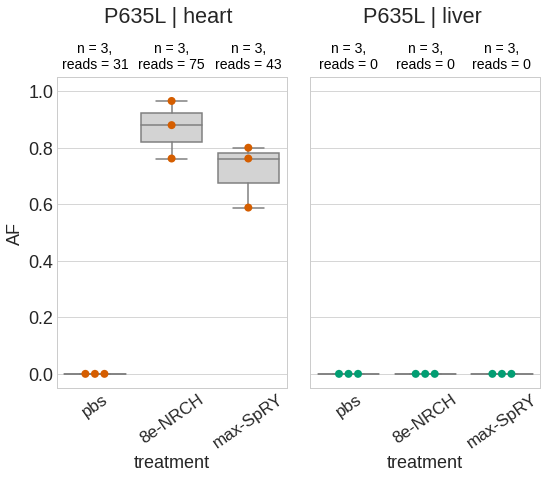

In [12]:
fig, ax = plt.subplots(1,2, figsize = (8,7), sharey = True)
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')
plot1 = sns.boxplot(x="treatment", y="AF", data=p365l[p365l['tissue'] == 'heart'], color = 'lightgrey', ax = ax[0])
sns.swarmplot(x="treatment", y="AF", data=p365l[p365l['tissue'] == 'heart'], size = 8, ax = ax[0], color = sns.color_palette('colorblind')[3])

plot2 = sns.boxplot(x="treatment", y="AF", data=p365l[p365l['tissue'] == 'liver'], color = 'lightgrey', ax = ax[1])
sns.swarmplot(x="treatment", y="AF", data=p365l[p365l['tissue'] == 'liver'], size = 8, ax = ax[1],color = sns.color_palette('colorblind')[2])

ax[0].set_xlabel('treatment')
ax[0].set_ylabel('AF')

ax[0].set_ylim(-0.05,1.05)

ax[1].set(ylabel=None)

ax[0].set_title('P635L | heart \n \n')
ax[1].set_title('P635L | liver \n \n')

order = ['pbs','8e-NRCH', 'max-SpRY']
for count, xtick in enumerate(ax[0].get_xticks()):
    ax[0].text(xtick,1.08, f'n = 3,\nreads = {int(p365l.groupby(["tissue", "treatment"])["reads"].sum()["heart"][order[count]])}',
            horizontalalignment='center',color='black', size = 14)

for count, xtick in enumerate(ax[1].get_xticks()):
    ax[1].text(xtick,1.08, f'n = 3,\nreads = {int(p365l.groupby(["tissue", "treatment"])["reads"].sum()["liver"][order[count]])}',
            horizontalalignment='center',color='black', size = 14)

plot1.set_xticklabels(plot1.get_xticklabels(), 
                          rotation=35, 
                          fontsize = 17)
plot2.set_xticklabels(plot2.get_xticklabels(), 
                          rotation=35, 
                          fontsize = 17)

fig.tight_layout()
plt.show()

# save figure

fig.savefig(f'{outdir}/P635L_ontarget_AF.pdf', bbox_inches = 'tight')
fig.savefig(f'{outdir}/P635L_ontarget_AF.svg', bbox_inches = 'tight')

In [8]:
# save dataframes as txt files
p365l.to_csv(f'{outdir}/p635l.txt', index = False)
r636q.to_csv(f'{outdir}/r636q.txt', index = False)